In [18]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras_preprocessing.image import ImageDataGenerator


from ml.eval import eval_model
from ml.pipeline import FeitDataPipeline
from tensorflow import keras

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import concatenate

from cfg import *

from livelossplot import PlotLossesKerasTF

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

name = "MySimpleCnn_Feit-reduced-rgb-no-inception"


/home/jelinek/recetox


In [19]:
class MySimpleCNNInceptionModule(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.params.tile_size=256


    @staticmethod
    def get_compiled_model():
        inputs = keras.Input(shape=(256, 256, 3))

        x = keras.layers.Conv2D(filters=16, kernel_size=5, strides=(1, 1), padding='same')(inputs)

        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=32, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = keras.layers.Conv2D(filters=64, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=128, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=256, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = keras.layers.Conv2D(filters=512, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Flatten()(x)
        outputs = keras.layers.Dense(units=12, activation='softmax')(x)

        model = keras.Model(inputs, outputs, name='MySimpleCnnFewerLayers')
        model.summary()
        return model

    def get_data_loader_training(self):
        datagen_train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, samplewise_center=True,
                                           samplewise_std_normalization=True)

        return datagen_train.flow_from_directory(directory=self.params.data_training, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=True,
                                                 target_size=(self.params.tile_size, self.params.tile_size))

    def get_data_loader_validation(self):
        datagen_valid = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
        return datagen_valid.flow_from_directory(directory=self.params.data_validation, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=False,
                                                 target_size=(self.params.tile_size, self.params.tile_size))


    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=200,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()])

In [20]:
pipeline = MySimpleCNNInceptionModule(train_data_dir='data/Feit_colon-annotation-tiles-256/data_train/',
                        valid_data_dir='data/Feit_colon-annotation-tiles-256/data_valid/')

Model: "MySimpleCnnFewerLayers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 256, 256, 16)      1216      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 32)      12832     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 64, 64, 

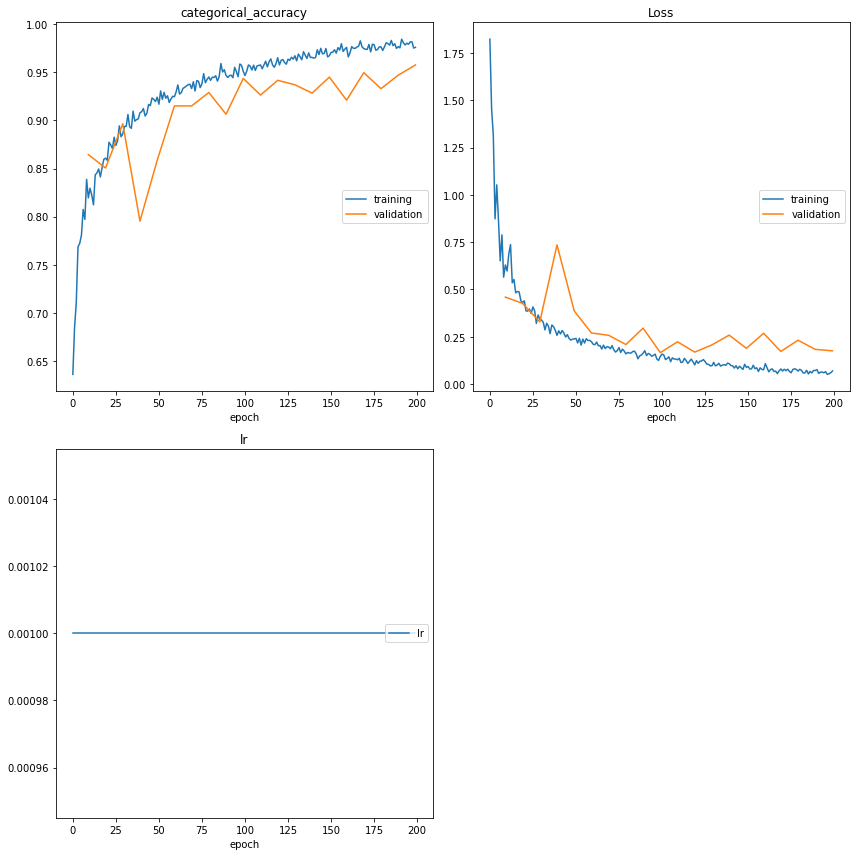

categorical_accuracy
	training         	 (min:    0.636, max:    0.984, cur:    0.976)
	validation       	 (min:    0.795, max:    0.957, cur:    0.957)
Loss
	training         	 (min:    0.051, max:    1.823, cur:    0.069)
	validation       	 (min:    0.166, max:    0.736, cur:    0.176)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
95/95 [==============================] - 5s 48ms/step - loss: 0.1756 - categorical_accuracy: 0.9575
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.3995ms
Confusion Matrix
[[326   0   0   0   2   0   1   0   0   0   6   0]
 [  3  49   7   1   0   0   3   1   0   0   0   0]
 [  2   0 140   0   0   0   1   1   0   0   1   0]
 [  0   0   0  10   1   0   0   0   0   0   0   0]
 [  1   0   0   1 542   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  1   2   0   0   0   0  74   0   0   0   0   0]
 [  0   1   2   0   0   0   6  77   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   

In [21]:
pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [22]:
pipeline.save_pipeline()

In [23]:
eval_model(pipeline.model,
           pipeline.get_data_loader_validation(),
           print_confusion_matrix=True,
           save_misclassified=True)

Found 1505 images belonging to 12 classes.
95/95 [==============================] - 5s 48ms/step - loss: 0.1756 - categorical_accuracy: 0.9575
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.3922ms
Confusion Matrix
[[326   0   0   0   2   0   1   0   0   0   6   0]
 [  3  49   7   1   0   0   3   1   0   0   0   0]
 [  2   0 140   0   0   0   1   1   0   0   1   0]
 [  0   0   0  10   1   0   0   0   0   0   0   0]
 [  1   0   0   1 542   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  1   2   0   0   0   0  74   0   0   0   0   0]
 [  0   1   2   0   0   0   6  77   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0]
 [ 16   0   0   0   1   0   0   0   0   0 217   0]
 [  0   0   0   0   0   0   0   0   0   0   1   5]]
Classification Report
                             precision    recall  f1-score   support

             adenocarcinoma       0.93      0.97      0.95 

In [24]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)

In [25]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1)

Processing region 120 out of 120
Processing image took 1864.635814666748 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-inception-v2-reduced-rgb/ns-adenoca-colon-15071-2019-20x-he-4.tiff
Processing region 255 out of 255
Processing image took 4492.699262857437 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-inception-v2-reduced-rgb/ns-adenoca-colon-15072-2019-20x-he-a2.tiff
Processing region 255 out of 255
Processing image took 4343.875237226486 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-inception-v2-reduced-rgb/ns-adenoca-colon-3043-2019-20x-he-a1.tiff
Processing region 56 out of 56
Processing image took 859.5419564247131 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-inception-v2-reduced-rgb/ns-adenoca-colon-lupos-15071-2019-20x-he-14.tiff
Processing region 567 out of 567
Processing image took 9847.778131484985 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-inception-v2-reduced-